In [1]:
# Importing libraries

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima import model_selection

In [2]:
# Loading dataset

df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [3]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,678,712,726,736,750,766,773,782,789,795
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,731,738,738,743,743,743,745,745,747,748
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,25,25,26,27,27,27,27,30,35,35


In [4]:
# Data Cleaning

df_US = df.loc[df['Country/Region'] == 'US']
ds_US = list(df_US.columns[4:].values)
y_US = np.transpose(df_US[df_US.columns[4:]].values)
df_US = pd.DataFrame(y_US, index=pd.to_datetime(ds_US), columns=['confirmedCases'])

In [5]:
df_US.head()

,confirmedCases
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5


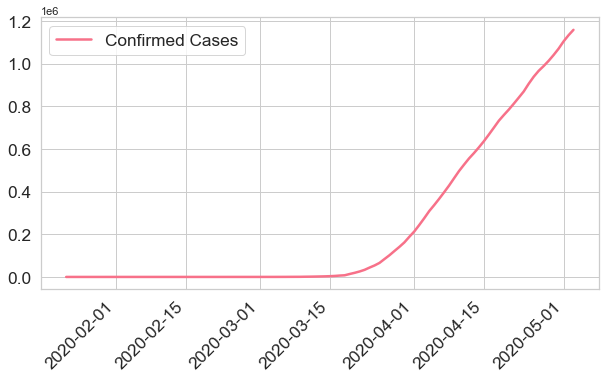

In [20]:
# Confirmed cases plot

plt.figure(figsize=(10,5))
chart = sns.lineplot(
    data=df_US,
    legend=False,
    palette="husl", 
    linewidth=2.5)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.yticks(
    fontweight='light',
    fontsize='x-large'  
)
plt.legend(labels=['Confirmed Cases'], fontsize="x-large")
plt.savefig('confirmedCases.png')
plt.show()

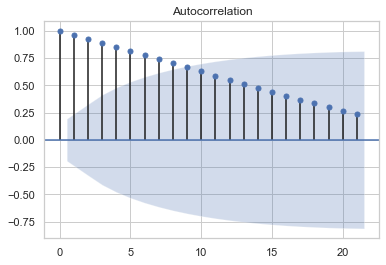

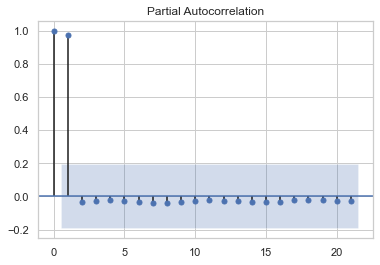

In [21]:
# Autocorrelation and partial autocorrelation plots

plot_acf(df_US['confirmedCases'])
plt.savefig('autocorrelation.png')
plot_pacf(df_US['confirmedCases'])
plt.savefig('partialAutocorrelation.png')
plt.show()

In [22]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolling = timeseries.rolling(12)
    rolmean = rolling.mean()
    rolstd = rolling.std()

    #Plot rolling statistics:
    plt.figure(figsize=(10,5))
    orig = plt.plot(timeseries, color='blue',label='Original', linewidth=2.0)
    mean = plt.plot(rolmean, color='red', label='Rolling Mean', linewidth=2.0)
    std = plt.plot(rolstd, color='black', label = 'Rolling Std', linewidth=2.0)
    plt.legend(loc='best', fontsize="large")
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='large'  
    )
    plt.yticks(
        fontweight='light',
        fontsize='large'  
    )
    plt.savefig('stationarity.png')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

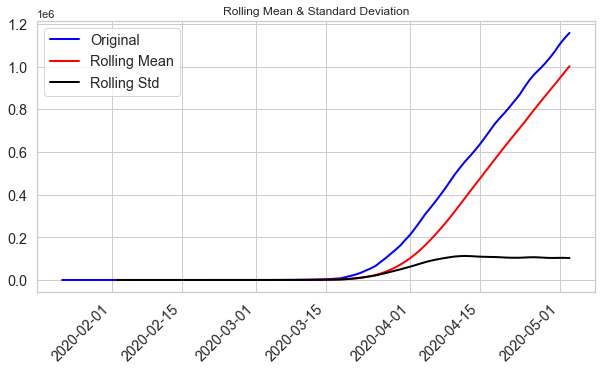

Results of Dickey-Fuller Test:
Test Statistic                 -1.428321
p-value                         0.568626
#Lags Used                     12.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


In [23]:
# Stationarity plot and ADF Test

test_stationarity(df_US['confirmedCases'])

In [10]:
# Train-test split

train, test = model_selection.train_test_split(df_US['confirmedCases'].values, train_size=0.85)

In [11]:
# Building our model

model = pm.auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)

In [12]:
# Forecasting data

forecasts = model.predict(test.shape[0])

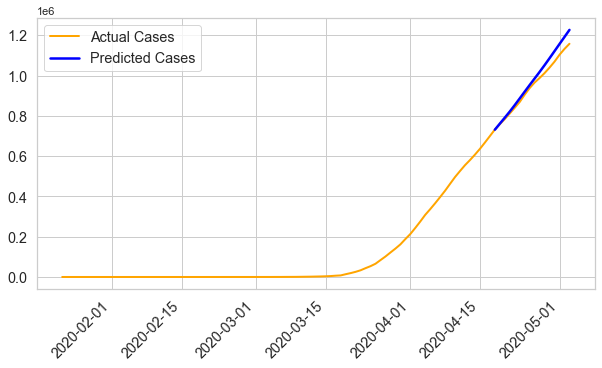

In [24]:
# Predicted cases vs Actual cases plot

plt.figure(figsize=(10,5))
plt.plot(df_US.index, df_US['confirmedCases'].values, c='orange', linewidth=2.0)
plt.plot(df_US.index[train.shape[0]:], forecasts, c='blue', linewidth=2.5)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
plt.yticks(
    fontweight='light',
    fontsize='large'  
)
plt.legend(labels=['Actual Cases', 'Predicted Cases'], fontsize="large")
plt.savefig('arima_future.png')
plt.show()

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   87
Model:               SARIMAX(3, 2, 2)   Log Likelihood                -735.462
Date:                Mon, 04 May 2020   AIC                           1484.924
Time:                        22:23:06   BIC                           1502.023
Sample:                             0   HQIC                          1491.802
                                 - 87                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    349.3754    336.117      1.039      0.299    -309.403    1008.153
ar.L1          0.7436      0.138      5.390      0.000       0.473       1.014
ar.L2         -0.5165      0.157     -3.291      0.001      -0.824      -0.209
ar.L3         -0.2656      0.147     -1.811      0.070      -0.553       0.022
ma.L1         -0.8394      0.169     -4.956      0.000      -1.171      -0.507
ma.L2          0.9914      0.379      2.615      0.009       0.248       1.734
sigma2      1.815e+06   6.52e+05      2.781      0.005    5.36e+05    3.09e+06
===================================================================================
Ljung-Box (Q):                       42.06   Jarque-Bera (JB):               303.22
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):              51.57   Skew:                             1.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
print('Mean Absolute Percentage Error: ', pm.metrics.smape(test,forecasts))

Mean Absolute Percentage Error:  2.6816303919382682
